# Третья версия.

 - Входные данные, пары: `BTC/USDT, ETH/USDT, BNB/USDT`,
 - Создание целевой функции по окну усреднения, с определением локальных максимумов и минимумов,
 - Устранены двойные сделки за один такт, оставлена сделка с наибольшим профитом,
 - Устранены подряд идущие одинаковые сделки в паре (выбраны сделки с максимумом для продажи и минимумом для покупки)
 - созданы признаки `(trend - trend.mean)/trend.std` на BASE. 
 - создан загрузчик данных (признаки при обучении подаются последовательно),
 - созданы две нейросети на свёртках и макспулинг (отличие в размере ядра и паддинга)
 - при добавлении fee (комиссии сделки) в тесте, кошелёк быстро тает пир большом количестве сделок.
 - созданы две функции проверки, с разной логикой реализации покупки.
 - проверка проводится на другом признаковом поле `delta/(min-max)`, чем обучение сетей `(trend - trend.mean)/trend.std`. 
 - первая функция проверки сохраняет статистику в DataFrame для удобства анализа.
 - Если при продаже выбирать только прибыльные сделки для компенсиции fee, то система приближается к какому то уровню кошелька и перестаёт торговать (вероятно сделки идут по продаже одной валюты, количество валюты уменьшается и системе нечем торговать).

## Импорты

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import time
from datetime import datetime

from tqdm import tqdm

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import phik
from phik.report import plot_correlation_matrix
from phik import report

import seaborn as sns

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
import torch.optim as optim

pd.set_option("display.max_columns", None)
RANDOM = 1111
PERIOD = 100
FEATURES_LENGHT = 224
BATCH_SIZE = 512
EPOCH = 5
FEE = 0.001

# Создание признаков

## Считывание данных из файла

In [17]:
trend = pd.read_csv('binance_features/BTC_ETH_BNB_train_5.csv', sep=';', names=['BTC/USTD','ETH/USTD','BNB/USTD', 'server_time'])
trend['server_time'] = trend['server_time'].apply(lambda x: datetime.utcfromtimestamp(int(str(x)[:10])).strftime('%Y-%m-%d %H:%M:%S'))
trend['server_time'] = pd.to_datetime(trend['server_time'])
trend = trend.set_index('server_time')
trend['numeric_index'] = range(trend.shape[0])

## Получение среза по датам

In [18]:
#trend = trend[(trend.index >= datetime(2022, 7, 17)) & (trend.index < datetime(2022, 7, 18))]
#trend = trend[47000:51000]

## Создание признаков

### 'BTC/BNB', 'BTC/ETH', 'ETH/BNB'

In [19]:
trend['BTC/BNB'] = trend['BTC/USTD']/trend['BNB/USTD']
trend['BTC/ETH'] = trend['BTC/USTD']/trend['ETH/USTD']
trend['ETH/BNB'] = trend['ETH/USTD']/trend['BNB/USTD']

#### delta BASE

In [20]:
trend['BTC/ETH_delta'] = trend['BTC/ETH'] - trend['BTC/ETH'].shift(1)
trend['BTC/BNB_delta'] = trend['BTC/BNB'] - trend['BTC/BNB'].shift(1)
trend['ETH/BNB_delta'] = trend['ETH/BNB'] - trend['ETH/BNB'].shift(1)

### ratio

In [21]:
trend['btc_bnb_ratio'] = trend['BTC/BNB']/trend['BTC/BNB'][0]
trend['btc_eth_ratio'] = trend['BTC/ETH']/trend['BTC/ETH'][0]
trend['eth_bnb_ratio'] = trend['ETH/BNB']/trend['ETH/BNB'][0]

### mean
 Среднее по количеству стобцов PERIOD * 2 + 1

In [22]:
for column in ('btc_bnb_ratio', 'btc_eth_ratio', 'eth_bnb_ratio'):
    # создание столбцов shift
    for period in range(-PERIOD, (PERIOD+1)):
        trend[column + '_' + str(period)] = trend[column].shift(period)
    # получение среднего по столбцам  shift
    trend[column + '_mean'] = trend[[column + '_' + str(x) for x in range(-PERIOD, (PERIOD+1))]].mean(axis=1)
    # удаление столбцов shift
    trend = trend.drop(columns = [column + '_' + str(x) for x in range(-PERIOD, (PERIOD+1))])

C:\Users\denis\AppData\Local\Temp\ipykernel_9780\2594479708.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  trend[column + '_' + str(period)] = trend[column].shift(period)
C:\Users\denis\AppData\Local\Temp\ipykernel_9780\2594479708.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  trend[column + '_' + str(period)] = trend[column].shift(period)
C:\Users\denis\AppData\Local\Temp\ipykernel_9780\2594479708.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times

C:\Users\denis\AppData\Local\Temp\ipykernel_9780\2594479708.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  trend[column + '_' + str(period)] = trend[column].shift(period)
C:\Users\denis\AppData\Local\Temp\ipykernel_9780\2594479708.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  trend[column + '_' + str(period)] = trend[column].shift(period)
C:\Users\denis\AppData\Local\Temp\ipykernel_9780\2594479708.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times

C:\Users\denis\AppData\Local\Temp\ipykernel_9780\2594479708.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  trend[column + '_' + str(period)] = trend[column].shift(period)
C:\Users\denis\AppData\Local\Temp\ipykernel_9780\2594479708.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  trend[column + '_' + str(period)] = trend[column].shift(period)
C:\Users\denis\AppData\Local\Temp\ipykernel_9780\2594479708.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times

#### mean delta

In [23]:
trend['btc_eth_ratio_mean_delta'] = trend['btc_eth_ratio_mean'] - trend['btc_eth_ratio_mean'].shift(1)
trend['btc_bnb_ratio_mean_delta'] = trend['btc_bnb_ratio_mean'] - trend['btc_bnb_ratio_mean'].shift(1)
trend['eth_bnb_ratio_mean_delta'] = trend['eth_bnb_ratio_mean'] - trend['eth_bnb_ratio_mean'].shift(1)

### buy, sell

#### Минимумы и максимумы среднего

In [24]:
for column in ('btc_eth_ratio_mean_delta', 'btc_bnb_ratio_mean_delta', 'eth_bnb_ratio_mean_delta'):
    sign = np.sign(trend[column])
    column = '_'.join(column.split('_')[:-1])
    trend[column + '_min'] = ((sign*2+np.roll(sign,1)) == 1).astype('int')
    trend[column + '_max'] = ((sign*2+np.roll(sign,1)) == -1).astype('int')

#### Выбор локальных минимумов.

In [25]:
%%time
for column in ('btc_eth_ratio_mean_min', 'btc_bnb_ratio_mean_min', 'eth_bnb_ratio_mean_min'):

    list_idx = trend[trend[column] == 1]['numeric_index'].values
    for idx in list_idx:
#         print(idx)
        index_min = trend[trend['numeric_index'] == idx].index
        idx_range = range(idx-PERIOD, idx+PERIOD)
#         print(index_min)
        range_table = trend.query('numeric_index in @idx_range')['_'.join(column.split('_')[:-2])]
        range_table_min = range_table.min()
        index_buy = range_table[range_table == range_table_min].index
#         print(index_buy)
        trend.loc[index_min, column] = 0
        trend.loc[index_buy, column] = 1

CPU times: total: 25.6 s
Wall time: 22.8 s


#### Выбор локальных максимумов.

In [26]:
%%time
for column in ('btc_eth_ratio_mean_max', 'btc_bnb_ratio_mean_max', 'eth_bnb_ratio_mean_max'):

    list_idx = trend[trend[column] == 1]['numeric_index'].values
    for idx in list_idx:
#         print(idx)
        index_max = trend[trend['numeric_index'] == idx].index
        idx_range = range(idx-PERIOD, idx+PERIOD)
#         print(index_max)
        range_table = trend.query('numeric_index in @idx_range')['_'.join(column.split('_')[:-2])]
        range_table_max = range_table.max()
        index_sell = range_table[range_table == range_table_max].index
#         print(index_sell)
        trend.loc[index_max, column] = 0
        trend.loc[index_sell, column] = 1

CPU times: total: 24.3 s
Wall time: 22.6 s


#### Профит каждой сделки

In [27]:
for column in ('btc_bnb', 'btc_eth', 'eth_bnb'):
    trend[column + '_deal'] = trend[column + '_ratio_mean_min'] + trend[column + '_ratio_mean_max']
    trend[column + '_profit'] = abs(trend[trend[column + '_deal'] == 1][column + '_ratio'] - trend[trend[column + '_deal'] == 1][column + '_ratio'].shift(-1))

#### Более одной продажи (двойные сделки)

In [28]:
trend['duble_buy'] = (trend['btc_bnb_deal']+
                      trend['btc_eth_deal']+
                      trend['eth_bnb_deal'])>1

#### Устранение двойных сделок

In [29]:
trend['btc_bnb_profit'] = trend['btc_bnb_deal']*trend['btc_bnb_profit']
trend['btc_eth_profit'] = trend['btc_eth_deal']*trend['btc_eth_profit']
trend['eth_bnb_profit'] = trend['eth_bnb_deal']*trend['eth_bnb_profit']

trend['profit_max'] = trend[trend['duble_buy']][['btc_bnb_profit','btc_eth_profit','eth_bnb_profit']].idxmax(axis=1)

trend.loc[trend['profit_max'] == 'btc_bnb_profit',['btc_eth_ratio_mean_min', 'btc_eth_ratio_mean_max','eth_bnb_ratio_mean_min','eth_bnb_ratio_mean_max']] = 0
trend.loc[trend['profit_max'] == 'btc_eth_profit',['btc_bnb_ratio_mean_min', 'btc_bnb_ratio_mean_max','eth_bnb_ratio_mean_min','eth_bnb_ratio_mean_max']] = 0
trend.loc[trend['profit_max'] == 'eth_bnb_profit',['btc_eth_ratio_mean_min', 'btc_eth_ratio_mean_max','btc_bnb_ratio_mean_min','btc_bnb_ratio_mean_max']] = 0

In [30]:
columns = ['btc_bnb', 'btc_eth', 'eth_bnb']
for column in columns:

    # Подтягиваем покупку и продажу к цене, для удобства отображения на графике и оценки сделок
    trend[column + '_min_price'] = trend[column + '_ratio_mean_min']*trend[column + '_ratio']
    trend[column + '_max_price'] = trend[column + '_ratio_mean_max']*trend[column + '_ratio']    

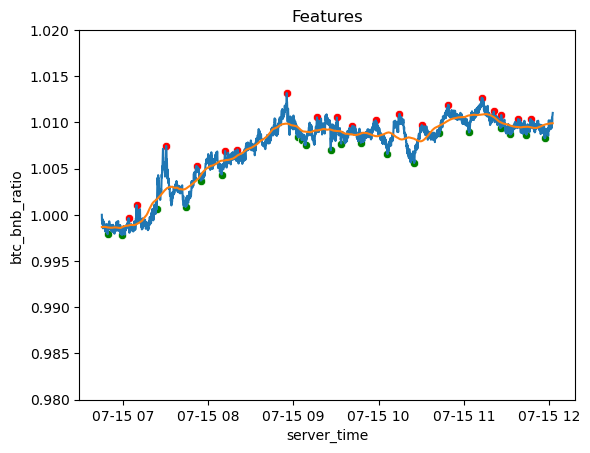

In [31]:
fig, ax = plt.subplots()
# sns.lineplot(data=trend[48000:50000], x='server_time', y ='btc_bnb_ratio', ax=ax)
# sns.lineplot(data=trend[48000:50000], x='server_time', y ='btc_bnb_ratio_mean', ax=ax)
# sns.scatterplot(data=trend[48000:50000], x='server_time', y ='btc_bnb_min_price', ax=ax, color='green')
# sns.scatterplot(data=trend[48000:50000], x='server_time', y ='btc_bnb_max_price', ax=ax, color='red')
sns.lineplot(data=trend[:3000], x='server_time', y ='btc_bnb_ratio', ax=ax)
sns.lineplot(data=trend[:3000], x='server_time', y ='btc_bnb_ratio_mean', ax=ax)
sns.scatterplot(data=trend[:3000], x='server_time', y ='btc_bnb_min_price', ax=ax, color='green')
sns.scatterplot(data=trend[:3000], x='server_time', y ='btc_bnb_max_price', ax=ax, color='red')
plt.title('Features')
plt.ylim([0.98, 1.02])
plt.show()

#### Устранение подряд идущих одинаковых сделок (продажа и покупка должны чередоваться)

In [32]:
columns = ['btc_bnb', 'btc_eth', 'eth_bnb']
for column in columns:


    # выделение локальных максимумов через разницу со сдвигами +- 1, обе разницы должны быть положительными
    max_price = trend[(trend[column + '_max_price'] - trend[column + '_min_price']) !=0][column + '_max_price']
    max_price_true = (max_price-max_price.shift(-1) > 0) & (max_price-max_price.shift(1) > 0)
    trend[column + '_max_price'] = (trend[column + '_max_price']*max_price_true).fillna(0)
    trend[column + '_ratio_mean_max'] = max_price_true
    trend[column + '_ratio_mean_max'] = trend[column + '_ratio_mean_max'].fillna(0).astype('int')


    # выделение локальных минимумов через разницу со сдвигами +- 1, обе разницы должны быть отрицательными.
    # предварительно 0 заменяем на 10, заведомо больше максимумов.
    min_price = trend[(trend[column + '_max_price'] - trend[column + '_min_price']) !=0][column + '_min_price']
    min_price.loc[min_price == 0] =10
    min_price_true = (min_price-min_price.shift(-1) < 0) & (min_price-min_price.shift(1) < 0)
    trend[column + '_min_price'] = (trend[column + '_min_price']*min_price_true).fillna(0)
    trend[column + '_ratio_mean_min'] = min_price_true
    trend[column + '_ratio_mean_min'] = trend[column + '_ratio_mean_min'].fillna(0).astype('int')

del max_price, max_price_true, min_price, min_price_true

C:\Users\denis\AppData\Local\Temp\ipykernel_9780\571222238.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  min_price.loc[min_price == 0] =10
C:\Users\denis\AppData\Local\Temp\ipykernel_9780\571222238.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  min_price.loc[min_price == 0] =10
C:\Users\denis\AppData\Local\Temp\ipykernel_9780\571222238.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  min_price.loc[min_price == 0] =10


#### График

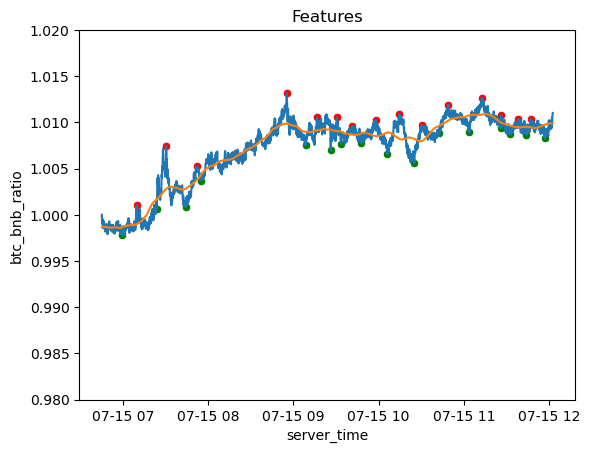

In [33]:
fig, ax = plt.subplots()
# sns.lineplot(data=trend[48000:50000], x='server_time', y ='btc_bnb_ratio', ax=ax)
# sns.lineplot(data=trend[48000:50000], x='server_time', y ='btc_bnb_ratio_mean', ax=ax)
# sns.scatterplot(data=trend[48000:50000], x='server_time', y ='btc_bnb_min_price', ax=ax, color='green')
# sns.scatterplot(data=trend[48000:50000], x='server_time', y ='btc_bnb_max_price', ax=ax, color='red')
sns.lineplot(data=trend[:3000], x='server_time', y ='btc_bnb_ratio', ax=ax)
sns.lineplot(data=trend[:3000], x='server_time', y ='btc_bnb_ratio_mean', ax=ax)
sns.scatterplot(data=trend[:3000], x='server_time', y ='btc_bnb_min_price', ax=ax, color='green')
sns.scatterplot(data=trend[:3000], x='server_time', y ='btc_bnb_max_price', ax=ax, color='red')
plt.title('Features')
plt.ylim([0.98, 1.02])
plt.show()

### not_buy

In [34]:
trend['not_buy'] = ((trend['btc_bnb_ratio_mean_min']+
                     trend['btc_bnb_ratio_mean_max']+
                     trend['btc_eth_ratio_mean_min']+
                     trend['btc_eth_ratio_mean_max']+
                     trend['eth_bnb_ratio_mean_min']+
                     trend['eth_bnb_ratio_mean_max']) == 0).astype('int')

### Обрезка датафрейма с верху и низу на PERIOD

In [35]:
trend = trend.iloc[PERIOD+1:-PERIOD-1]

In [36]:
trend.shape

(76563, 40)

### Распределение классов

In [37]:
trend[['btc_bnb_ratio_mean_min',
       'btc_bnb_ratio_mean_max',
       'btc_eth_ratio_mean_min',
       'btc_eth_ratio_mean_max',
       'eth_bnb_ratio_mean_min',
       'eth_bnb_ratio_mean_max',
       'not_buy']].sum()*100/trend.shape[0]

btc_bnb_ratio_mean_min     0.398365
btc_bnb_ratio_mean_max     0.397059
btc_eth_ratio_mean_min     0.300406
btc_eth_ratio_mean_max     0.297794
eth_bnb_ratio_mean_min     0.365712
eth_bnb_ratio_mean_max     0.380079
not_buy                   97.860585
dtype: float64

In [38]:
trend.shape

(76563, 40)

## Создание признаков методом отжига?

## PyTorch

### Выделение признаков

#### Признаковое поле (trend - trend.mean) / trend.std

In [25]:
X2_temp = trend[['BTC/BNB','BTC/ETH','ETH/BNB']]

In [26]:
X2_temp.shape

(76563, 3)

In [26]:
# нулевая подложка
# X2 = np.empty([76542, 3, 224])
X2 = np.zeros((1,3,FEATURES_LENGHT))

for i in tqdm(range(FEATURES_LENGHT, X2_temp.shape[0])):
#     X2_trend = torch.from_numpy(X2_temp.iloc[i-FEATURES_LENGHT+1:i+1].values)
    X2_trend = X2_temp.iloc[i-FEATURES_LENGHT+1:i+1].values
    X2_trend = (X2_trend - X2_trend.T.mean(axis=1))/X2_trend.T.std(axis=1)
    X2_trend = X2_trend.T
    X2_trend = np.expand_dims(X2_trend, axis=0)
    X2 = np.append(X2, X2_trend, axis=0)
    
# удаление нулевой подложки np.zeros
X2 = X2[1:]   

100%|████████████████████████████████████████████████████████████████████████████| 76339/76339 [38:51<00:00, 32.75it/s]


In [27]:
X2.shape

(76339, 3, 224)

In [28]:
np.save('binance_features/nparray2', X2, allow_pickle=True, fix_imports=True)

#### Признаковое поле delta / (delta.max - delta.min)

In [40]:
X = X2

#### Целевая функция

y

- not_buy - 0
- btc_bnb_ratio_mean_min - 1	
- btc_bnb_ratio_mean_max - 2	
- btc_eth_ratio_mean_min - 3
- btc_eth_ratio_mean_max - 4	
- eth_bnb_ratio_mean_min - 5	
- eth_bnb_ratio_mean_max - 6

In [41]:
Y = trend[['btc_bnb_ratio_mean_min','btc_bnb_ratio_mean_max','btc_eth_ratio_mean_min','btc_eth_ratio_mean_max','eth_bnb_ratio_mean_min','eth_bnb_ratio_mean_max','not_buy']]

Y=Y.rename(
    columns={
        'not_buy':'0',
        'btc_bnb_ratio_mean_min':'1',
        'btc_bnb_ratio_mean_max':'2',
        'btc_eth_ratio_mean_min':'3',
        'btc_eth_ratio_mean_max':'4',
        'eth_bnb_ratio_mean_min':'5',
        'eth_bnb_ratio_mean_max':'6'        
    }
)

y = Y.idxmax(axis=1)[FEATURES_LENGHT:]

In [42]:
print(X.shape, y.shape)

(76339, 3, 224) (76339,)


##### Устранение дисбаланса целевой функции

In [43]:
values, counts = np.unique(y, return_counts=True)
print(values, counts)

['0' '1' '2' '3' '4' '5' '6'] [74706   304   303   229   227   279   291]


In [44]:
i, = np.where(y == '1')
X_1 = X[i]
y_1 = y[i]
i, = np.where(y == '2')
X_2 = X[i]
y_2 = y[i]
i, = np.where(y == '3')
X_3 = X[i]
y_3 = y[i]
i, = np.where(y == '4')
X_4 = X[i]
y_4 = y[i]
i, = np.where(y == '5')
X_5 = X[i]
y_5 = y[i]
i, = np.where(y == '6')
X_6 = X[i]
y_6 = y[i]

In [45]:
for i in tqdm(range(250)):
    X = np.concatenate((X, X_1, X_2, X_3, X_4, X_5, X_6), axis=0)
    y = np.concatenate((y, y_1, y_2, y_3, y_4, y_5, y_6), axis=0)

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [01:04<00:00,  3.85it/s]


In [46]:
values, counts = np.unique(y, return_counts=True)
print(values, counts)

['0' '1' '2' '3' '4' '5' '6'] [74706 76304 76053 57479 56977 70029 73041]


In [47]:
print(X.shape, y.shape)

(484589, 3, 224) (484589,)


#### Перемешивание признаков и создание выборк

In [48]:
for i in range (10):
    X, y = shuffle(X, y, random_state=RANDOM*i)

In [49]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.025, random_state=RANDOM, shuffle=True)

### Загрузчики данных

In [51]:
X_tensor = torch.tensor(X_train.astype('float32'))
y_tensor = torch.tensor(y_train.astype('int')).type(torch.LongTensor)
X_valid_tensor = torch.tensor(X_valid.astype('float32'))
y_valid_tensor = torch.tensor(y_valid.astype('int')).type(torch.LongTensor)

train = data_utils.TensorDataset(X_tensor, y_tensor)
train_loader = data_utils.DataLoader(train, batch_size=BATCH_SIZE, shuffle=False)

In [52]:
X_valid_tensor.shape

torch.Size([12115, 3, 224])

In [53]:

X_valid_tensor = X_valid_tensor.to('cuda')
y_valid_tensor = y_valid_tensor.to('cuda')
print(X_valid_tensor.shape, y_valid_tensor.shape)

torch.Size([12115, 3, 224]) torch.Size([12115])


### Модель 1

#### Конструктор модели 1

In [54]:
class Net_1(nn.Module):
    def __init__(self):
        super(Net_1,self).__init__()
        self.conv1 = nn.Conv1d(3, 6, 3)
        self.pool = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(6, 12, 2)
        self.fc1 = nn.Linear(660, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 7)
        self.sm = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def inference(self, x):
        x = self.forward(x)
        x = self.sm(x)
        return x

In [55]:
net_1 = Net_1().to('cuda')

#### Обучение модели 1

In [56]:
%%time

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_1.parameters(), lr=0.0001)

for epoch in range(EPOCH):
    loss_array = np.array([], dtype=float)
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()
        X_batch, y_batch = batch
        X_batch = X_batch.to('cuda')
        y_batch = y_batch.to('cuda')
        output = net_1.forward(X_batch)
#         print(output, output.shape, output.type())
#         print(y_batch, y_batch.shape, y_batch.type())
        loss =loss_fn(output, y_batch)
        loss.backward()
        optimizer.step()
        loss_array = np.append(loss_array, loss.to('cpu').detach().numpy())
    if epoch % 2 == 0:
        predict = torch.argmax(net_1.inference(X_valid_tensor), dim=1)
        good = (predict == y_valid_tensor).sum()
        accuracy = good/y_valid_tensor.shape[0]
        print(f'Epoch: {epoch}, loss: {loss_array.mean():.3f}, accuracy: {accuracy:.3f}')

Epoch: 0, loss: 1.575, accuracy: 0.493
Epoch: 2, loss: 0.818, accuracy: 0.788
Epoch: 4, loss: 0.392, accuracy: 0.925
CPU times: total: 37.1 s
Wall time: 37.1 s


In [57]:
predict = torch.argmax(net_1.inference(X_valid_tensor), dim=1)
good = (predict == y_valid_tensor).sum()
accuracy = good/y_valid_tensor.shape[0]
print(accuracy)

tensor(0.9246, device='cuda:0')


### Модель 2

#### Конструктор модели 2

In [58]:
class Net_2(nn.Module):
    def __init__(self):
        super(Net_2,self).__init__()
        self.conv1 = nn.Conv1d(3, 9, 3, stride=1, padding=2, padding_mode='replicate')
        self.pool = nn.MaxPool1d(3)
        self.conv2 = nn.Conv1d(9, 18, 2, stride=1, padding=2, padding_mode='replicate')
        self.fc1 = nn.Linear(468, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 7)
        self.sm = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def inference(self, x):
        x = self.forward(x)
        x = self.sm(x)
        return x

In [59]:
net_2 = Net_2().to('cuda')

#### Обучение модели 2

In [60]:
%%time

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_2.parameters(), lr=0.0001)

for epoch in range(EPOCH):
    loss_array = np.array([], dtype=float)
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()
        X_batch, y_batch = batch
        X_batch = X_batch.to('cuda')
        y_batch = y_batch.to('cuda')
        output = net_2.forward(X_batch)
#         print(output, output.shape, output.type())
#         print(y_batch, y_batch.shape, y_batch.type())
        loss =loss_fn(output, y_batch)
        loss.backward()
        optimizer.step()
        loss_array = np.append(loss_array, loss.to('cpu').detach().numpy())
    if epoch % 2 == 0:
        predict = torch.argmax(net_2.inference(X_valid_tensor), dim=1)
        good = (predict == y_valid_tensor).sum()
        accuracy = good/y_valid_tensor.shape[0]
        print(f'Epoch: {epoch}, loss: {loss_array.mean():.3f}, accuracy: {accuracy:.3f}')

Epoch: 0, loss: 1.410, accuracy: 0.568
Epoch: 2, loss: 0.762, accuracy: 0.773
Epoch: 4, loss: 0.433, accuracy: 0.914
CPU times: total: 34.4 s
Wall time: 34.4 s


In [61]:
predict = torch.argmax(net_2.inference(X_valid_tensor), dim=1)
good = (predict == y_valid_tensor).sum()
accuracy = good/y_valid_tensor.shape[0]
print(accuracy)

tensor(0.9137, device='cuda:0')


## Проверка модели при продаже на тестовых данных

In [62]:
trend_test = pd.read_csv('binance_features/BTC_ETH_BNB_test.csv', sep=';', names=['BTC/USTD','ETH/USTD','BNB/USTD', 'server_time'])
trend_test['server_time'] = trend_test['server_time'].apply(lambda x: datetime.utcfromtimestamp(int(str(x)[:10])).strftime('%Y-%m-%d %H:%M:%S'))
trend_test['server_time'] = pd.to_datetime(trend_test['server_time'])
trend_test = trend_test.set_index('server_time')
#trend_test = trend_test[50_000:55_000]

In [63]:
trend_test['BTC/BNB'] = trend_test['BTC/USTD']/trend_test['BNB/USTD']
trend_test['BTC/ETH'] = trend_test['BTC/USTD']/trend_test['ETH/USTD']
trend_test['ETH/BNB'] = trend_test['ETH/USTD']/trend_test['BNB/USTD']

### Проверка модели 1

`coin_byu` - словарь для валюты:
 - `name` - название валюты,
 - `quantity` - количество на счёте,
 - `price_usdt` - текущая цена в долларах.
 
`trade_result` - DataFrame статистики по торгам:
 - `server_time` - время сервера,
 - `btc_in_usdt` - количество BTC  в колшельке определённое в долларах,
 - `bnb_in_usdt` - количество BNB  в колшельке определённое в долларах,
 - `eth_in_usdt` - количество ETH  в колшельке определённое в долларах,
 - `fee_usdt` - размер комиссии со сделки определённой в долларах,
 - `predict` - предсказание по сделке,
 - `predict_proba` - вероятность предсказания по сделке,
 - `price` - стоимость в паре (валюта покупки/ валюта продажи),
 - `profit_function` - прибыль со сделки в долларах вычесленная в функции,
 - `quantity_in_usdt` - размер кошелька в долларах,
 - `profit_in_usdt` - прибыль со сделки в долларах вычесленная как разность размера кошелька после сделки и до сделки,
 - `BTC/USTD` - стоимость в паре.

Функция выполнения сделки.

In [64]:
# coin_buy = {'name': 'BTC','quantity': 21, 'price_usdt': 19275}

def buy(coin_buy, coin_sell, price, proba):
    
    all_coin_in_usdt_before = coin_buy['quantity']*coin_buy['price_usdt'] + coin_sell['quantity']*coin_sell['price_usdt']
    
    coin_sell_part = proba * np.clip((coin_sell['quantity']*coin_sell['price_usdt'])
                                        /(coin_buy['quantity']*coin_buy['price_usdt']), 0, 0.1) * coin_sell['quantity']
    coin_buy_part = coin_sell_part / price
    fee = FEE * coin_buy_part
    coin_sell_out = coin_sell['quantity'] - coin_sell_part
    coin_buy_out = coin_buy['quantity'] + coin_buy_part - fee
    
    all_coin_in_usdt_after = coin_buy_out*coin_buy['price_usdt'] + coin_sell_out*coin_sell['price_usdt']
    profit = all_coin_in_usdt_after - all_coin_in_usdt_before
    
    # условие для совершения сделки
    if True: #profit > 0.01:
        coin_buy_out = coin_buy_out
        coin_sell_out = coin_sell_out
    else:
        coin_buy_out = coin_buy['quantity']
        coin_sell_out = coin_sell['quantity']
    return coin_buy_out, coin_sell_out, fee*coin_buy['price_usdt'], profit
    


Функция выравнивания баланса в кошелке (равная доля валют в долларах в кошельке)

Поток данных организую в цикле, каждый цикл - имитация считывания в интервале 5 сек с сервака.

In [69]:
btc = {'name': 'BTC', 'quantity': 100/19275, 'price_usdt': 19275}
bnb = {'name': 'BNB', 'quantity': 100/275, 'price_usdt': 275}
eth = {'name': 'ETH', 'quantity': 100/1306, 'price_usdt': 1306}

btc_in_usdt = btc['quantity']*btc['price_usdt']
bnb_in_usdt = bnb['quantity']*bnb['price_usdt']
eth_in_usdt = eth['quantity']*eth['price_usdt']

step_prev = trend_test[['BTC/BNB','BTC/ETH','ETH/BNB']].iloc[0]
columns_result = ['server_time','btc_in_usdt', 'bnb_in_usdt', 'eth_in_usdt', 'fee_usdt', 'predict', 'predict_proba', 'price', 'profit_function']
data = dict(zip(columns_result,[[step_prev.name],[btc_in_usdt], [bnb_in_usdt], [eth_in_usdt], [0], [0], [0], [0], [0]]))
trade_result = pd.DataFrame(data)

features_delta = np.zeros((1,3))
predicts = np.zeros(0)
predicts_proba = np.zeros(0)


net_2 = net_1.to('cpu')

for step in tqdm(trend_test[['BTC/BNB','BTC/ETH','ETH/BNB']].iloc[1:].iterrows()):
    time = step[0]
    step = step[1:][0]
    delta = step - step_prev
    delta_exp = np.expand_dims(delta, axis=0)
    features_delta = np.append(features_delta, delta_exp, axis=0)
    feattures_delta_transp = features_delta[-FEATURES_LENGHT:].T
    step_prev = step
    
    # условие достаточного количества признаков для предсказания
    if feattures_delta_transp.shape[1] == FEATURES_LENGHT:
        max_min = feattures_delta_transp.max(axis=1) - feattures_delta_transp.min(axis=1)
        features = np.divide(feattures_delta_transp.T, max_min).T
        features = np.expand_dims(features, axis=0)
        print(features.shape)
        print(features)
        features = torch.tensor(features.astype('float32'))
        predict_proba = net_2.inference(features)
        predict = torch.argmax(predict_proba, dim=1).detach().item()
        predict_proba = predict_proba.max().detach().item()

        # действия с валютой
        if predict == 0:
            fee_usdt = 0
            price = 0
            profit = 0
            
        if predict == 1: # btc_bnb_buy
            price = step[0]
            btc['quantity'], bnb['quantity'], fee_usdt, profit = buy(btc, bnb, price, predict_proba)
            
        if predict == 2: # btc_bnb_sell
            price = 1/step[0]
            bnb['quantity'], btc['quantity'], fee_usdt, profit = buy(bnb, btc, price, predict_proba)            
            
        if predict == 3: # btc_eth_buy
            price = step[1]
            btc['quantity'], eth['quantity'], fee_usdt, profit = buy(btc, eth, price, predict_proba)
            
        if predict == 4: # btc_eth_sell
            price = 1/step[1]
            eth['quantity'], btc['quantity'], fee_usdt, profit = buy(eth, btc, price, predict_proba)
            
        if predict == 5: # eth_bnb_buy
            price = step[2]
            eth['quantity'], bnb['quantity'], fee_usdt, profit = buy(eth, bnb, price, predict_proba)
            
        if predict == 6: # eth_bnb_sell
            price = 1/step[2]
            bnb['quantity'], eth['quantity'], fee_usdt, profit = buy(bnb, eth, price, predict_proba)
        
        btc_in_usdt = btc['quantity']*btc['price_usdt']
        bnb_in_usdt = bnb['quantity']*bnb['price_usdt']
        eth_in_usdt = eth['quantity']*eth['price_usdt']
        
        data = dict(zip(columns_result,[[time],[btc_in_usdt], [bnb_in_usdt], [eth_in_usdt], [fee_usdt], [predict], [predict_proba], [price], [profit]]))
        current_result = pd.DataFrame(data)
        trade_result = pd.concat([trade_result, current_result])     

trade_result = trade_result[1:].set_index('server_time')

233it [00:00, 2244.12it/s]

(1, 3, 224)
[[[ 0.00000000e+00 -3.52284425e-01  7.51551113e-02 -1.12732667e-01
    1.48744491e-01 -3.15777459e-01  1.87126522e-01 -2.00674585e-01
   -2.20169555e-01  3.79874167e-01 -3.43877480e-01  3.87717961e-01
   -5.89758860e-02 -1.30477624e-01 -8.84484722e-02  1.83697138e-01
   -2.19172133e-01 -9.39044004e-03  1.09827936e-01  3.65337347e-02
   -6.78483644e-02 -9.42048444e-02 -2.71393458e-02 -2.34447942e-01
    3.66752253e-01 -1.44830162e-01 -1.02454826e-01  2.73887834e-02
    9.59424619e-02 -2.36277371e-01  1.66941156e-02  0.00000000e+00
   -5.73860224e-02  4.59898907e-01 -2.57221909e-01 -3.93876790e-02
    1.47865097e-01 -3.28370222e-01  1.33031234e-02 -1.27292632e-01
    1.38085912e-01  2.00335574e-01 -1.10952638e-01  7.93637695e-02
   -8.10657422e-02  1.30668098e-01  1.33389837e-01 -8.35759702e-03
    1.74464838e-01 -2.60598388e-01  3.49659032e-01  5.74584795e-03
   -2.59071883e-01  1.77524221e-02 -1.46196417e-02  2.68896982e-02
   -4.25347173e-02  6.78483644e-03  6.02899938e-02

[[[ 7.66267435e-02 -1.88708578e-01  1.33331550e-02  0.00000000e+00
   -4.58327203e-02  3.67309269e-01 -2.05436434e-01 -3.14579126e-02
    1.18095999e-01 -2.62260737e-01  1.06248579e-02 -1.01665307e-01
    1.10285618e-01  1.60002801e-01 -8.86149801e-02  6.33857740e-02
   -6.47450953e-02  1.04361204e-01  1.06534986e-01 -6.67499490e-03
    1.39340518e-01 -2.08133140e-01  2.79263555e-01  4.58905899e-03
   -2.06913960e-01  1.41783968e-02 -1.16763268e-02  2.14761011e-02
   -3.39713700e-02  5.41887201e-03  4.81520466e-02 -8.34023342e-04
   -2.16553565e-01  2.18839062e-02 -1.66734523e-03  1.42333992e-01
   -2.27785435e-01  1.11230673e-01  1.49290178e-01 -1.08006023e-01
   -7.67301475e-02  1.00499813e-01 -2.13382926e-01  4.23088853e-02
    2.19447394e-01 -1.85058399e-01 -5.11787131e-02  1.15371505e-01
    1.81749311e-01 -3.15345348e-01  2.70943601e-03  6.35675371e-02
   -4.27257216e-02  1.58141856e-01 -1.57213400e-01  2.23101244e-02
    7.71471592e-03 -1.55170516e-01  2.84652640e-01 -5.98411748

[[[-1.16763268e-02  2.14761011e-02 -3.39713700e-02  5.41887201e-03
    4.81520466e-02 -8.34023342e-04 -2.16553565e-01  2.18839062e-02
   -1.66734523e-03  1.42333992e-01 -2.27785435e-01  1.11230673e-01
    1.49290178e-01 -1.08006023e-01 -7.67301475e-02  1.00499813e-01
   -2.13382926e-01  4.23088853e-02  2.19447394e-01 -1.85058399e-01
   -5.11787131e-02  1.15371505e-01  1.81749311e-01 -3.15345348e-01
    2.70943601e-03  6.35675371e-02 -4.27257216e-02  1.58141856e-01
   -1.57213400e-01  2.23101244e-02  7.71471592e-03 -1.55170516e-01
    2.84652640e-01 -5.98411748e-02 -1.12057244e-01  1.87744862e-01
    4.94158830e-02  6.25517507e-04 -2.12675952e-02 -1.75144902e-02
   -1.70867726e-01  1.03166986e-01 -1.83407976e-02  2.63440547e-01
   -8.58716087e-02  4.06448692e-02  1.12196569e-01 -1.61174836e-01
   -1.06710095e-01 -1.45892708e-01  3.62276697e-01  1.68889727e-02
   -1.66579152e-01 -1.66734523e-03  7.10705906e-02  1.29219256e-02
    1.55688361e-01 -8.96198064e-03 -2.83408829e-01  5.39576117

[[[-1.57213400e-01  2.23101244e-02  7.71471592e-03 -1.55170516e-01
    2.84652640e-01 -5.98411748e-02 -1.12057244e-01  1.87744862e-01
    4.94158830e-02  6.25517507e-04 -2.12675952e-02 -1.75144902e-02
   -1.70867726e-01  1.03166986e-01 -1.83407976e-02  2.63440547e-01
   -8.58716087e-02  4.06448692e-02  1.12196569e-01 -1.61174836e-01
   -1.06710095e-01 -1.45892708e-01  3.62276697e-01  1.68889727e-02
   -1.66579152e-01 -1.66734523e-03  7.10705906e-02  1.29219256e-02
    1.55688361e-01 -8.96198064e-03 -2.83408829e-01  5.39576117e-02
    5.56242560e-02 -1.16665106e-01 -8.12489133e-03 -1.51039647e-01
    2.72918010e-01 -1.89660520e-02  1.25050893e-02 -2.93956679e-01
    4.41660759e-02  1.73926395e-01 -1.07260620e-01  1.73329175e-01
   -3.44160224e-01  1.57000721e-01 -2.14708283e-01  1.52808091e-01
    6.66938094e-03 -1.95913065e-02 -1.65302492e-01  3.83328206e-02
    1.06456909e-01 -4.74993647e-02 -6.64574445e-02  1.53227205e-01
    5.00203570e-02 -2.50121935e-01  1.64789463e-01  1.53485209

(1, 3, 224)
[[[-8.96198064e-03 -2.83408829e-01  5.39576117e-02  5.56242560e-02
   -1.16665106e-01 -8.12489133e-03 -1.51039647e-01  2.72918010e-01
   -1.89660520e-02  1.25050893e-02 -2.93956679e-01  4.41660759e-02
    1.73926395e-01 -1.07260620e-01  1.73329175e-01 -3.44160224e-01
    1.57000721e-01 -2.14708283e-01  1.52808091e-01  6.66938094e-03
   -1.95913065e-02 -1.65302492e-01  3.83328206e-02  1.06456909e-01
   -4.74993647e-02 -6.64574445e-02  1.53227205e-01  5.00203570e-02
   -2.50121935e-01  1.64789463e-01  1.53485209e-01 -1.63179052e-02
    2.90314126e-02 -1.24842474e-01  3.41805773e-02  6.07964612e-02
    1.09658537e-01 -1.14935068e-01  7.67624413e-02 -1.29867544e-01
    1.11967634e-01 -3.34292349e-01  2.29288705e-01 -1.90955884e-01
    1.24998328e-03  6.87490805e-03 -4.70827036e-02  2.44502968e-01
    8.93718440e-02  1.41783968e-02 -1.18556348e-01 -1.04209077e-02
   -2.18839062e-02  6.60685549e-02  1.46510334e-01 -1.51512370e-01
    1.82365885e-01 -5.50223928e-02 -5.73149925e-02

[[[-2.50121935e-01  1.64789463e-01  1.53485209e-01 -1.63179052e-02
    2.90314126e-02 -1.24842474e-01  3.41805773e-02  6.07964612e-02
    1.09658537e-01 -1.14935068e-01  7.67624413e-02 -1.29867544e-01
    1.11967634e-01 -3.34292349e-01  2.29288705e-01 -1.90955884e-01
    1.24998328e-03  6.87490805e-03 -4.70827036e-02  2.44502968e-01
    8.93718440e-02  1.41783968e-02 -1.18556348e-01 -1.04209077e-02
   -2.18839062e-02  6.60685549e-02  1.46510334e-01 -1.51512370e-01
    1.82365885e-01 -5.50223928e-02 -5.73149925e-02  8.25335891e-02
    8.88162961e-02 -1.54468015e-01  1.69688941e-01 -8.00691343e-02
   -7.10705906e-02  8.29504254e-02  2.51048917e-01 -8.75724509e-03
    1.87655252e-02 -1.31421105e-01  1.82296529e-01 -2.67982761e-01
   -9.83170499e-02  9.91236742e-02  1.32941587e-01 -4.31364665e-01
   -1.17766582e-01  1.77616721e-01  6.97321102e-02  9.53352432e-02
   -1.99829331e-02 -1.97860242e-01  1.24840900e-02 -7.90659030e-03
    7.90659030e-03  2.69697764e-02  1.07374243e-01  1.70759271

(1, 3, 224)
[[[ 1.82365885e-01 -5.50223928e-02 -5.73149925e-02  8.25335891e-02
    8.88162961e-02 -1.54468015e-01  1.69688941e-01 -8.00691343e-02
   -7.10705906e-02  8.29504254e-02  2.51048917e-01 -8.75724509e-03
    1.87655252e-02 -1.31421105e-01  1.82296529e-01 -2.67982761e-01
   -9.83170499e-02  9.91236742e-02  1.32941587e-01 -4.31364665e-01
   -1.17766582e-01  1.77616721e-01  6.97321102e-02  9.53352432e-02
   -1.99829331e-02 -1.97860242e-01  1.24840900e-02 -7.90659030e-03
    7.90659030e-03  2.69697764e-02  1.07374243e-01  1.70759271e-02
    1.16846564e-01 -3.74930155e-02 -4.91866844e-02 -1.08169022e-01
    1.23375744e-01 -2.24769291e-01 -1.70974785e-02  1.27855269e-01
   -9.23900505e-02  2.04299110e-01 -2.34241907e-01  6.15311569e-03
    1.19311272e-01 -1.62299645e-01  9.84976300e-02 -7.30384968e-02
    1.99680077e-01 -3.71609394e-02 -6.60426311e-02 -1.39160193e-02
    3.63125424e-01 -9.39857847e-02 -1.58221798e-01 -1.31052412e-02
   -1.14261198e-01  5.79646223e-02  2.32408107e-01

[[[ 7.90659030e-03  2.69697764e-02  1.07374243e-01  1.70759271e-02
    1.16846564e-01 -3.74930155e-02 -4.91866844e-02 -1.08169022e-01
    1.23375744e-01 -2.24769291e-01 -1.70974785e-02  1.27855269e-01
   -9.23900505e-02  2.04299110e-01 -2.34241907e-01  6.15311569e-03
    1.19311272e-01 -1.62299645e-01  9.84976300e-02 -7.30384968e-02
    1.99680077e-01 -3.71609394e-02 -6.60426311e-02 -1.39160193e-02
    3.63125424e-01 -9.39857847e-02 -1.58221798e-01 -1.31052412e-02
   -1.14261198e-01  5.79646223e-02  2.32408107e-01 -2.98329343e-01
    2.11660861e-01  1.35808527e-01  5.75280795e-02  1.37209784e-01
   -1.70194467e-01  7.50868438e-02  3.43223641e-01  3.51960710e-01
   -5.25370080e-01  2.26264813e-01 -1.54198571e-01  1.32171088e-01
   -1.98073363e-01 -3.20403717e-01  4.74629920e-01  1.11306741e-01
   -3.29114262e-01  3.62141639e-01 -1.07390904e-01 -1.10506695e-01
   -2.97661830e-01  3.45437280e-01 -7.31172115e-02  2.01487770e-02
    1.62502463e-01 -2.20717030e-01 -2.91525856e-01  3.15225728

458it [00:01, 243.73it/s] 

(1, 3, 224)
[[[ 4.67181070e-02  1.87315407e-01 -2.40446356e-01  1.70593620e-01
    1.09458443e-01  4.63662639e-02  1.10587823e-01 -1.37172693e-01
    6.05182104e-02  2.76630092e-01  2.83671961e-01 -4.23435790e-01
    1.82364058e-01 -1.24280381e-01  1.06526753e-01 -1.59642420e-01
   -2.58237776e-01  3.82540428e-01  8.97105859e-02 -2.65258268e-01
    2.91877548e-01 -8.65545149e-02 -8.90657677e-02 -2.39908356e-01
    2.78414233e-01 -5.89307335e-02  1.62394351e-02  1.30973120e-01
   -1.77892677e-01 -2.34962907e-01  2.54064440e-01  2.64740545e-02
   -1.25445484e-01  3.35394790e-01 -2.76134442e-01 -1.68629393e-01
    1.54820142e-02  7.45630016e-02 -1.26054732e-01  5.46753192e-02
   -1.64211852e-01 -3.68057013e-03 -8.17378266e-02  1.04679408e-01
   -3.85220221e-02  4.62434281e-02 -1.97149262e-01  2.15748123e-01
   -1.78733485e-01 -2.29457262e-02  1.00492231e-02  5.14185251e-02
    3.42118018e-01 -3.08285633e-01  1.96964774e-01  4.23742243e-02
    2.61279802e-02 -9.18359025e-02  2.96327836e-02

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [66]:
trade_result = pd.merge(trade_result, trend_test, on='server_time')
trade_result['quantity_in_usdt'] = trade_result[['btc_in_usdt','bnb_in_usdt','eth_in_usdt']].sum(axis=1)
trade_result['profit_in_usdt'] = trade_result['quantity_in_usdt'] - trade_result['quantity_in_usdt'].shift(1) 

#### Общие статистики после торгов

In [67]:
print('Usdt after trade :', trade_result['quantity_in_usdt'][-1])
print('Sum all fee in usdt:', trade_result['fee_usdt'].sum())
print('Sum all profit in usdt > 0:', trade_result[trade_result['profit_in_usdt'] > 0]['profit_in_usdt'].sum())
print('Sum all profit in usdt <= 0:', trade_result[trade_result['profit_in_usdt'] <= 0]['profit_in_usdt'].sum())

Usdt after trade : 267.41117339318157
Sum all fee in usdt: 2.722637814896094
Sum all profit in usdt > 0: 254.84172965884187
Sum all profit in usdt <= 0: -286.77406618652265


#### Изменение объёма валют в кошельке

In [228]:
print(f'Распределение валют после торгов в USDT:\n',
      f'BTC - {trade_result["btc_in_usdt"][-1]:.4f}\n BNB - {trade_result["bnb_in_usdt"][-1]:.4f}\n ETH - {trade_result["eth_in_usdt"][-1]:.4f}\n')

Распределение валют после торгов в USDT:
 BTC - 0.3910
 BNB - 0.2737
 ETH - 309.7541



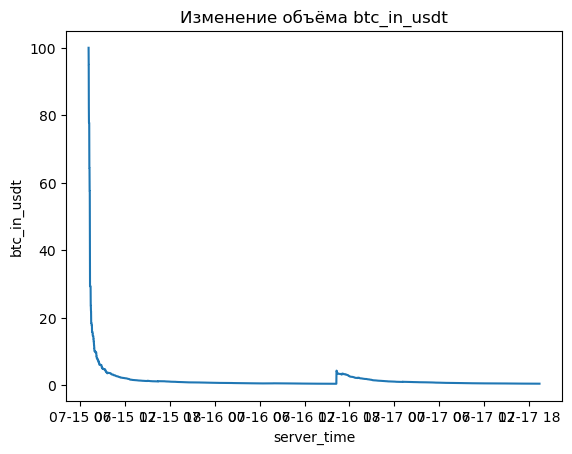

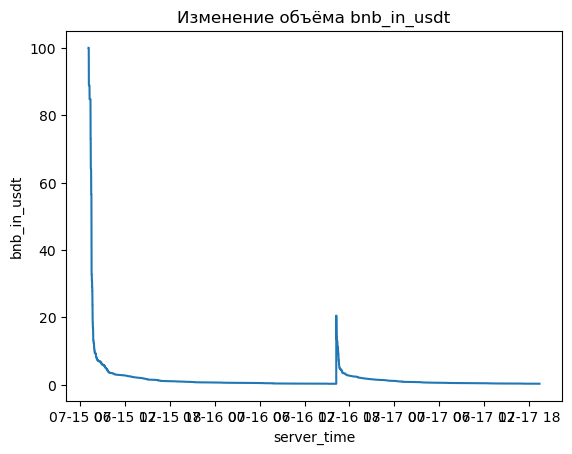

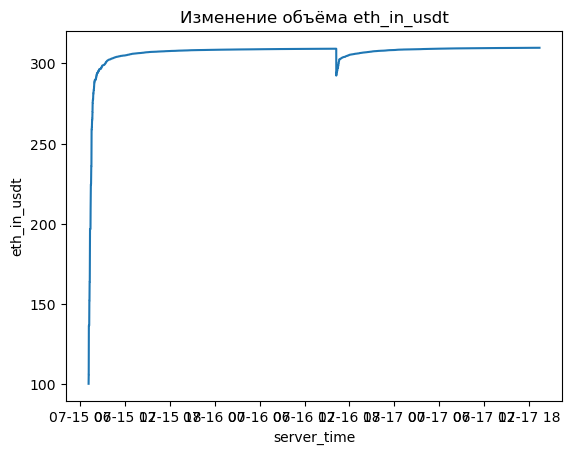

In [229]:
columns = ['btc_in_usdt','bnb_in_usdt','eth_in_usdt']

for column in columns:
    sns.lineplot(data=trade_result, x="server_time", y=column)
    plt.title('Изменение объёма ' + column)
    plt.show()

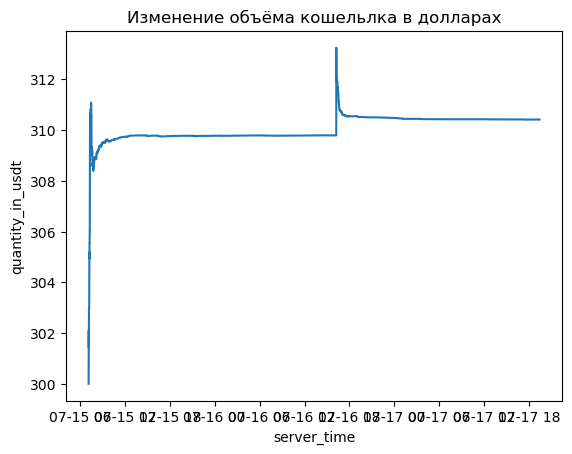

In [230]:
sns.lineplot(data=trade_result, x="server_time", y="quantity_in_usdt")
plt.title('Изменение объёма кошельлка в долларах')
plt.show()

#### Распределение операций за время торгов

In [231]:
trade_result.groupby('predict')['price'].count()

predict
0    28803
1       25
4     2848
5     2518
6        1
Name: price, dtype: int64

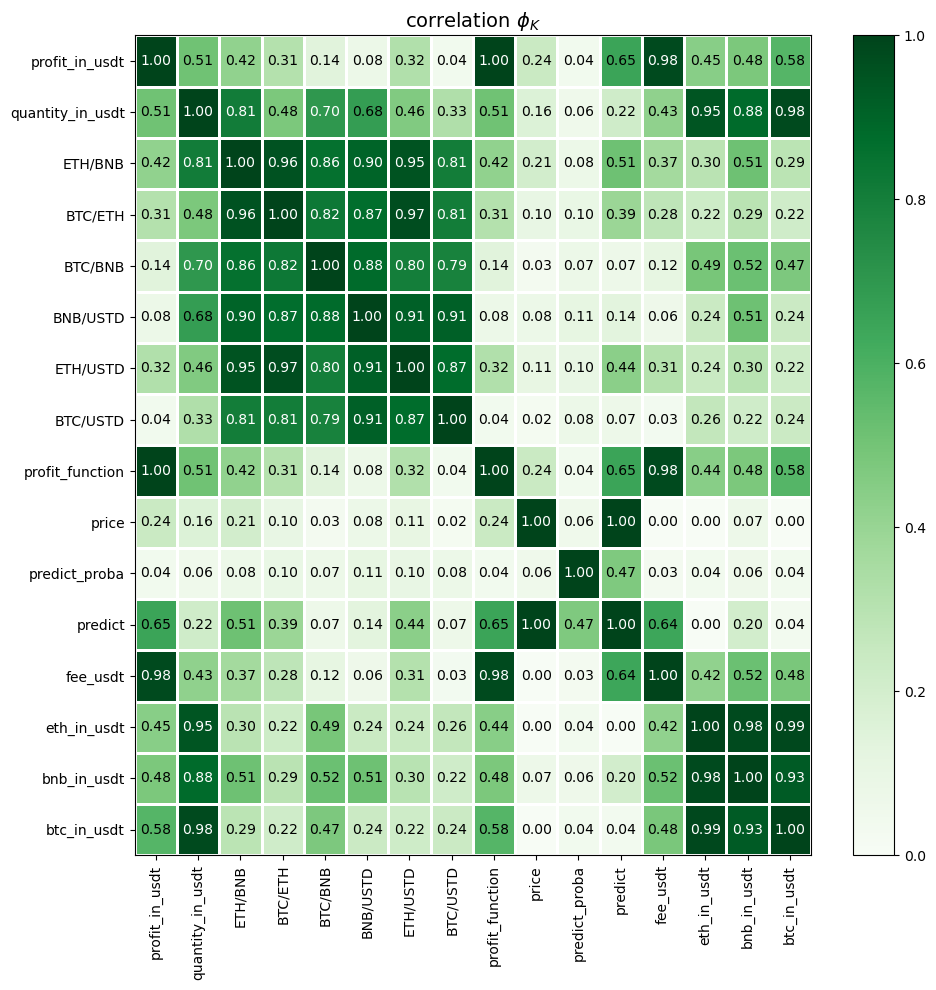

In [232]:
interval_cols = trade_result.columns
phik_overview = pd.DataFrame(trade_result, columns=interval_cols).phik_matrix(interval_cols=interval_cols)


plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1, 
                        figsize=(10, 10))
plt.tight_layout()

<AxesSubplot:xlabel='server_time', ylabel='profit_in_usdt'>

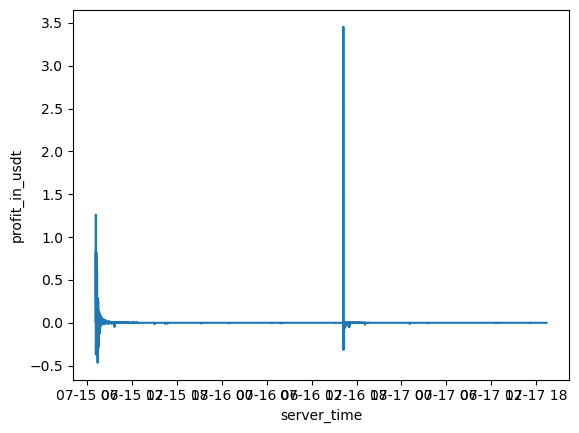

In [233]:
sns.lineplot(data=trade_result, x="server_time", y="profit_in_usdt")

<AxesSubplot:xlabel='server_time', ylabel='fee_usdt'>

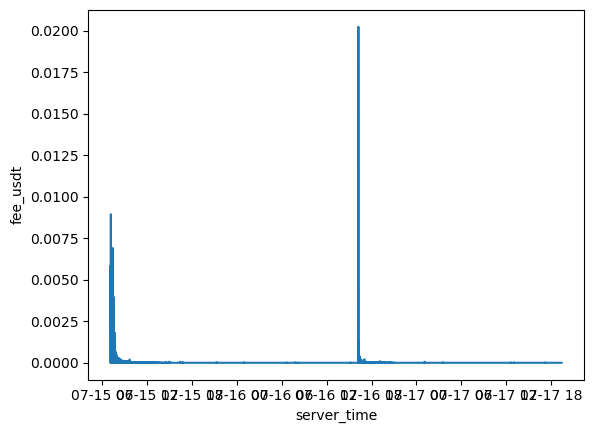

In [234]:
sns.lineplot(data=trade_result, x="server_time", y="fee_usdt")

<AxesSubplot:xlabel='profit_in_usdt', ylabel='Count'>

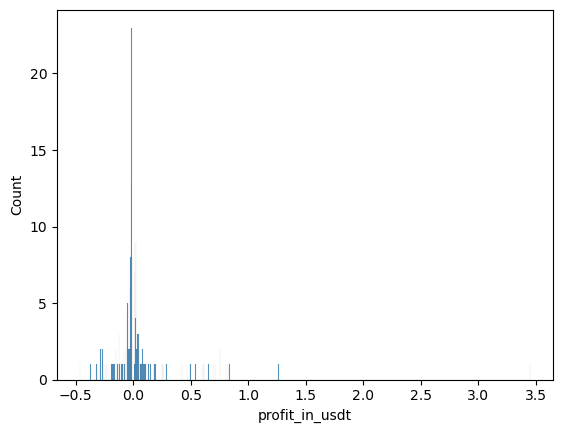

In [235]:
sns.histplot(data=trade_result[abs(trade_result['profit_in_usdt']) > 0.01], x="profit_in_usdt", bins = 1000)

#### Продажи на тренде.

In [236]:
trade_result['BTC/BNB_buy_price'] = trade_result['BTC/BNB']*(trade_result['predict'] == 1)
trade_result['BTC/BNB_sell_price'] = trade_result['BTC/BNB']*(trade_result['predict'] == 2)
trade_result['BTC/ETH_buy_price'] = trade_result['BTC/ETH']*(trade_result['predict'] == 3)
trade_result['BTC/ETH_sell_price'] = trade_result['BTC/ETH']*(trade_result['predict'] == 4)
trade_result['ETH/BNB_buy_price'] = trade_result['ETH/BNB']*(trade_result['predict'] == 5)
trade_result['ETH/BNB_sell_price'] = trade_result['ETH/BNB']*(trade_result['predict'] == 6)

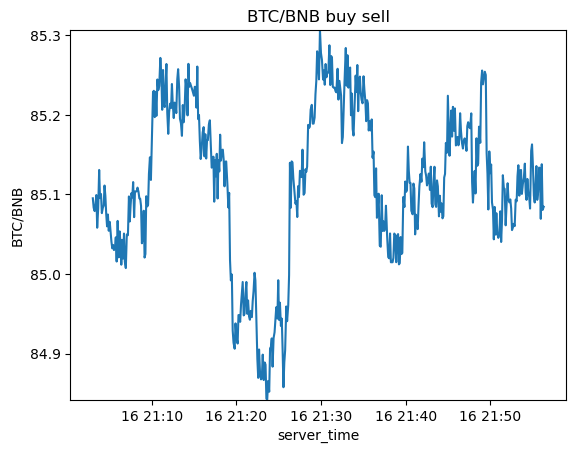

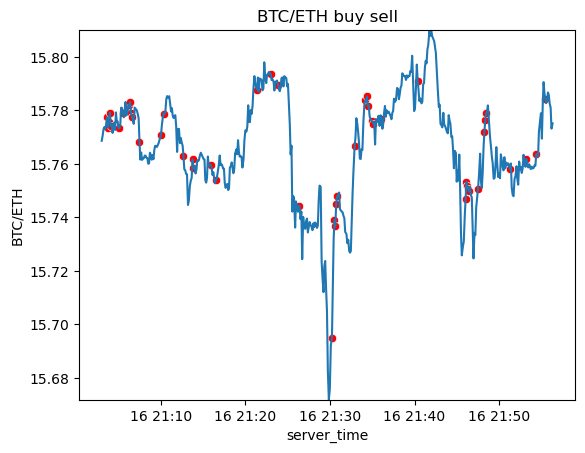

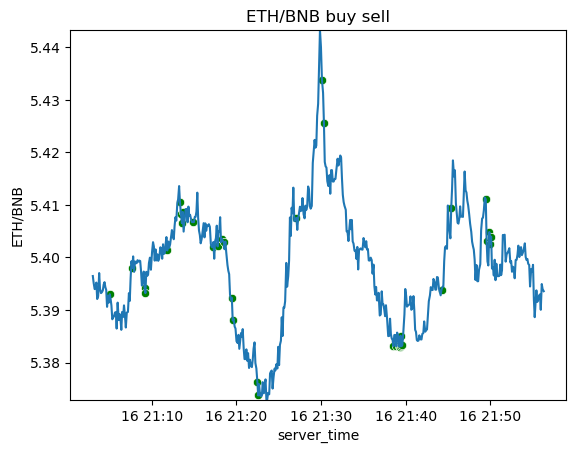

In [237]:
range_trade_begin = 21_500
range_trade_end = 22_000
columns = ['BTC/BNB','BTC/ETH','ETH/BNB']

for column in columns:
    fig, ax = plt.subplots()
    sns.lineplot(data=trade_result[range_trade_begin:range_trade_end], x='server_time', y =column, ax=ax)
    sns.scatterplot(data=trade_result[range_trade_begin:range_trade_end], x='server_time', y =column + '_buy_price', ax=ax, color='green')
    sns.scatterplot(data=trade_result[range_trade_begin:range_trade_end], x='server_time', y =column + '_sell_price', ax=ax, color='red')
    plt.title(column + ' buy sell')
    plt.ylim([trade_result[column][range_trade_begin:range_trade_end].min(), trade_result[column][range_trade_begin:range_trade_end].max()])
    plt.show()

### Проверка модели 2

Поток данных организую в цикле, каждый цикл - имитация считывания в интервале 5 сек с сервака.

In [88]:
btc = 100/19275
bnb = 100/275
eth = 100/1306
usdt = np.array([btc*19275+bnb*275+eth*1306])
not_buy = 0
btc_bnb_buy = 0
btc_bnb_sell = 0
btc_eth_buy = 0
btc_eth_sell = 0
eth_bnb_buy = 0
eth_bnb_sell = 0

fee = FEE

net_2 = net_2.to('cpu')

step_prev = trend_test[['BTC/BNB','BTC/ETH','ETH/BNB']].iloc[0]
features_delta = np.zeros((1,3))
predicts = np.zeros(1)

print(f'USDT before traid: {usdt[0]}')

for step in tqdm(trend_test[['BTC/BNB','BTC/ETH','ETH/BNB']].iloc[1:].iterrows()):
    step = step[1:][0]
    delta = step - step_prev
    delta_exp = np.expand_dims(delta, axis=0)
    features_delta = np.append(features_delta, delta_exp, axis=0)
    feattures_delta_transp = features_delta[-FEATURES_LENGHT:].T
    step_prev = step
    
    # условие достаточного количества признаков для предсказания
    if feattures_delta_transp.shape[1] == FEATURES_LENGHT:
        max_min = feattures_delta_transp.max(axis=1) - feattures_delta_transp.min(axis=1)
        features = np.divide(feattures_delta_transp.T, max_min).T
        features = np.expand_dims(features, axis=0)
        features = torch.tensor(features.astype('float32'))
#        features = features.to('cuda')
        predict_proba = net_1.inference(features)
        predict = torch.argmax(predict_proba, dim=1)
#         predicts = np.append(predicts, predict.to('cpu'), axis=0)
#         predict_proba = predict_proba.to('cpu')
        predicts = np.append(predicts, predict, axis=0)
        
        # действия с валютой
        if predict == 0:
            not_buy += 1
        elif predict == 1:
            btc_bnb_buy += 1

            bnb_sell = predict_proba.max().detach()*np.clip((bnb*275)/(btc*19275), 0, 0.6)*bnb
            bnb = bnb - bnb_sell
            btc = btc + (1-fee)*bnb_sell/step[0]
            
        elif predict == 2:
            btc_bnb_sell += 1
            
            btc_sell = predict_proba.max().detach()*np.clip((btc*19275)/(bnb*275), 0, 0.6)*btc
            btc = btc - btc_sell
            bnb = bnb + (1-fee)*btc_sell * step[0]
            
        elif predict == 3:
            btc_eth_buy += 1
            
            eth_sell = predict_proba.max().detach()*np.clip((eth*1306)/(btc*19275), 0, 0.6)*eth
            eth = eth - eth_sell
            btc = btc + (1-fee)*eth_sell/step[1]            
            
        elif predict == 4:
            btc_eth_sell += 1
            
            btc_sell = predict_proba.max().detach()*np.clip((btc*19275)/(eth*1306), 0, 0.6)*btc
            btc = btc - btc_sell
            eth = eth + (1-fee)*btc_sell * step[1]
            
        elif predict == 5:
            eth_bnb_buy += 1
            
            bnb_sell = predict_proba.max().detach()*np.clip((bnb*275)/(eth*1306), 0, 0.6)*bnb
            bnb = bnb - bnb_sell
            eth = eth + (1-fee)*bnb_sell/step[2]              
            
        elif predict == 6:
            eth_bnb_sell += 1
            
            eth_sell = predict_proba.max().detach()*np.clip((eth*1306)/(bnb*275), 0, 0.6)*eth
            eth = eth - eth_sell
            bnb = bnb + (1-fee)*eth_sell * step[2]            
            
            
        usdt = np.append(usdt, np.array([btc*19275+bnb*275+eth*1306]), axis=0)

print(f'USDT after traid: {usdt[-1]:.2f}')

USDT before traid: 300.0


76764it [00:57, 1340.91it/s]

USDT after traid: 312.22


Распределение торговых сделок:
 Нет сделки - 63904
 btc_bnb_buy - 78
 btc_bnb_sell - 1
 btc_eth_buy - 2
 btc_eth_sell - 6504
 eth_bnb_buy - 6052
 eth_bnb_sell - 1
Распределение валют после торгов в USDT:
 BTC - 11.3640
 BNB - 0.0143
 ETH - 300.8444



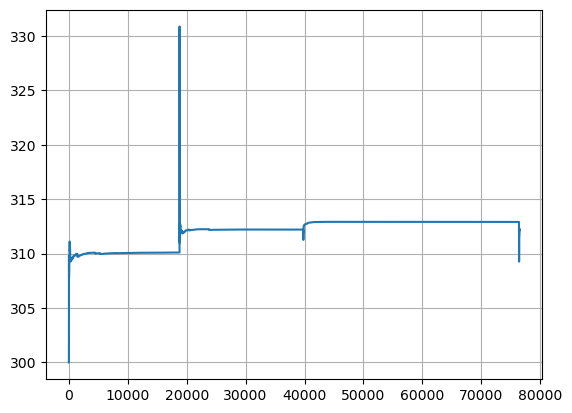

In [89]:
print(f'Распределение торговых сделок:\n',
      f'Нет сделки - {not_buy}\n btc_bnb_buy - {btc_bnb_buy}\n btc_bnb_sell - {btc_bnb_sell}\n'
      f' btc_eth_buy - {btc_eth_buy}\n btc_eth_sell - {btc_eth_sell}\n eth_bnb_buy - {eth_bnb_buy}\n eth_bnb_sell - {eth_bnb_sell}')

print(f'Распределение валют после торгов в USDT:\n',
      f'BTC - {btc*19275:.4f}\n BNB - {bnb*275:.4f}\n ETH - {eth*1306:.4f}\n')

plt.plot(usdt)
plt.grid(visible=True)
plt.show()

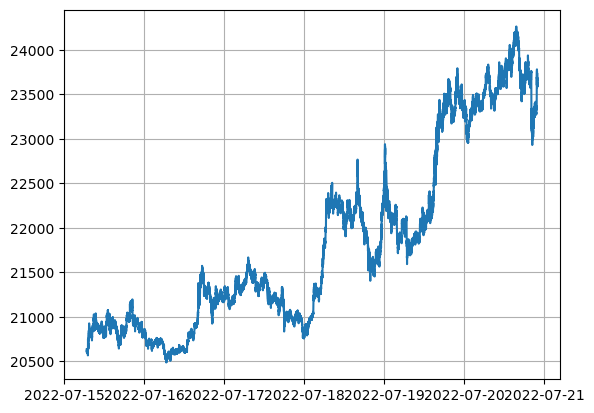

In [90]:
plt.plot(trend_test['BTC/USTD'])
plt.grid(visible=True)
plt.show()